# Defining common integrated photonic components

This notebook contains pre-defined functions used to construct commonly used photonic integrated circuit (PIC) components, including straight waveguide, linear taper, ring, race track, s-bend, circular bend, and directional coupler. These components are defined using the [gdstk](https://heitzmann.github.io/gdstk/) library as it offers a convenient and flexible way to construct curved paths. Users can directly copy these pre-defined functions to your own script and use them directly in building your simulations. More importantly, users can learn the workflow from these examples and build your own Tidy3D Structures using the same principles.

In [1]:
import tidy3d as td
import gdstk

import numpy as np
import matplotlib.pyplot as plt

## Straight Waveguide 

Straight strip waveguides are the most fundamental building block of any PIC. The function `straight_waveguide` returns a Tidy3D [Structure](../_autosummary/tidy3d.Structure.html) of a straight waveguide. The waveguide is specified by the starting position and the ending position. It only supports waveguides parallel to the $xy$ plane.

In [2]:
def straight_waveguide(x0, y0, z0, x1, y1, wg_width, wg_thickness, medium, sidewall_angle=0):
    """
    This function defines a straight strip waveguide and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide starting position (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("waveguide")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width, layer=1, datatype=0)  # define a path
    path.segment((x1, y1))

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    wg_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    wg = td.Structure(geometry=wg_geo[0], medium=medium)

    return wg

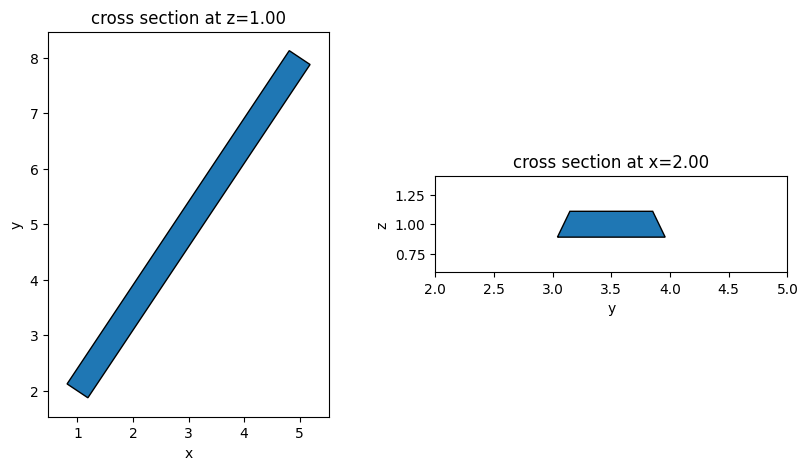

In [3]:
Si = td.material_library["cSi"]["Li1993_293K"]

wg = straight_waveguide(
    x0=1,
    y0=2,
    z0=1,
    x1=5,
    y1=8,
    wg_width=0.45,
    wg_thickness=0.22,
    medium=Si,
    sidewall_angle=15 * np.pi / 180,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
wg.plot(z=1, ax=ax1)
wg.plot(x=2, ax=ax2)
ax2.set_xlim(2, 5)
plt.show()

## Linear Waveguide Taper 

Linear waveguide tapers can be defined in a similar way. Two parameters - width at the start and width at the end of the taper, need to be specified.

In [4]:
def taper_waveguide(
    x0, y0, z0, x1, y1, wg_width_0, wg_width_1, wg_thickness, medium, sidewall_angle=0
):
    """
    This function defines a linear waveguide taper and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide starting position (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    wg_width_0: width of the waveguide in the beginning (um)
    wg_width_1: width of the waveguide in the end (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """
    cell = gdstk.Cell("taper")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width_0, layer=1, datatype=0)  # define a path
    path.segment((x1, y1), wg_width_1)

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    taper_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    taper = td.Structure(geometry=taper_geo[0], medium=medium)

    return taper

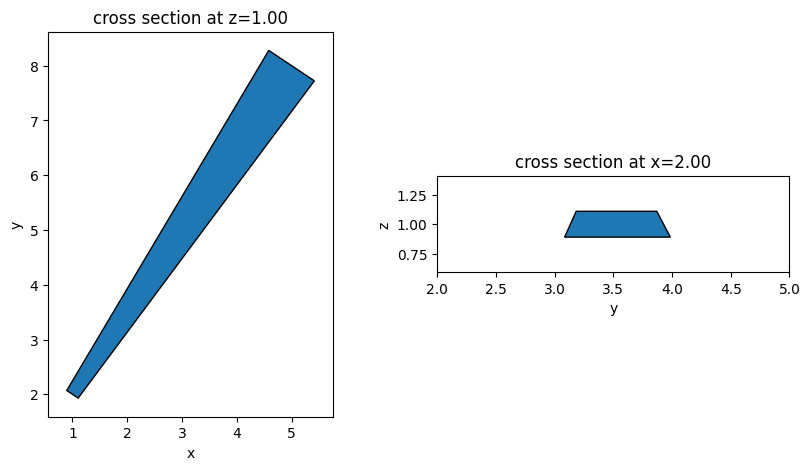

In [5]:
taper = taper_waveguide(
    x0=1,
    y0=2,
    z0=1,
    x1=5,
    y1=8,
    wg_width_0=0.25,
    wg_width_1=1,
    wg_thickness=0.22,
    medium=Si,
    sidewall_angle=15 * np.pi / 180,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
taper.plot(z=1, ax=ax1)
taper.plot(x=2, ax=ax2)
ax2.set_xlim(2, 5)
plt.show()

## Ring 

Rings are commonly used structures in PIC to construct resonators. Due to the hole, we can not define one single structure for the ring. Instead, we define two half rings and combine them to make one full ring.

In [6]:
def ring_resonator(
    x0,
    y0,
    z0,
    R,
    wg_width,
    wg_thickness,
    medium,
    sidewall_angle=0,
):
    """
    This function defines a ring and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of center of the ring (um)
    y0: y coordinate of center of the ring (um)
    z0: z coordinate of center of the ring (um)
    R: radius of the ring (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("top")  # define a gds cell

    # define a path
    path_top = gdstk.RobustPath(
        (x0 + R, y0), wg_width - wg_thickness * np.tan(np.abs(sidewall_angle)), layer=1, datatype=0
    )
    path_top.arc(R, 0, np.pi)  # make the top half of the ring
    cell.add(path_top)  # add path to the cell

    # the reference plane depends on the sign of the sidewall_angle
    if sidewall_angle >= 0:
        reference_plane = "top"
    else:
        reference_plane = "bottom"

    # define top half ring geometry
    ring_top_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
    )

    # similarly for the bottom half of the ring
    cell = gdstk.Cell("bottom")
    path_bottom = gdstk.RobustPath(
        (x0 + R, y0), wg_width - wg_thickness * np.tan(np.abs(sidewall_angle)), layer=1, datatype=0
    )

    path_bottom.arc(R, 0, -np.pi)
    cell.add(path_bottom)

    ring_bottom_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
    )

    # define ring structure
    ring = td.Structure(
        geometry=td.GeometryGroup(geometries=ring_bottom_geo + ring_top_geo), medium=medium
    )

    return ring

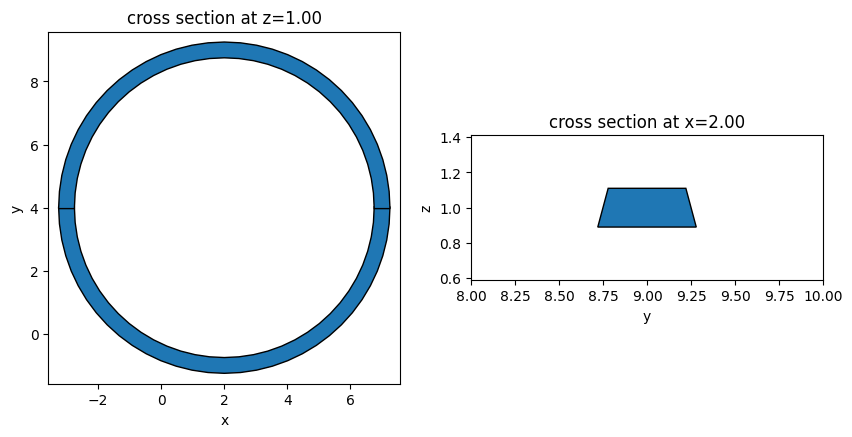

In [7]:
ring = ring_resonator(
    x0=2,
    y0=4,
    z0=1,
    R=5,
    wg_width=0.5,
    wg_thickness=0.22,
    medium=Si,
    sidewall_angle=15 * np.pi / 180,
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ring.plot(z=1, ax=ax1)
ring.plot(x=2, ax=ax2)
ax2.set_xlim(8, 10)
plt.show()

## Race Track

Similar to rings, race tracks are commonly used to construct resonators. The way to define a race track is similar to defining a ring. 

In [8]:
def race_track_resonator(
    x0,
    y0,
    z0,
    R,
    wg_length,
    wg_width,
    wg_thickness,
    medium,
    sidewall_angle=0,
):
    """
    This function defines a race track and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of center of the race track (um)
    y0: y coordinate of center of the race track (um)
    z0: z coordinate of center of the race track (um)
    R: radius of the circular part (um)
    wg_length: length of the straight waveguide (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("top")  # define a gds cell

    # define a path
    path_top = gdstk.RobustPath(
        (x0 + wg_length / 2 + R, y0),
        wg_width - wg_thickness * np.tan(np.abs(sidewall_angle)),
        layer=1,
        datatype=0,
    )

    # make the top half of the race track
    path_top.arc(R, 0, np.pi / 2)
    path_top.horizontal(x0 - wg_length / 2)
    path_top.arc(R, np.pi / 2, np.pi)

    cell.add(path_top)  # add path to the cell

    # the reference plane depends on the sign of the sidewall_angle
    if sidewall_angle >= 0:
        reference_plane = "top"
    else:
        reference_plane = "bottom"

    # define top half race track geometry
    race_track_top_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
    )

    # similarly for the bottom half of the race track
    cell = gdstk.Cell("bottom")
    path_bottom = gdstk.RobustPath(
        (x0 + wg_length / 2 + R, y0),
        wg_width - wg_thickness * np.tan(np.abs(sidewall_angle)),
        layer=1,
        datatype=0,
    )

    path_bottom.arc(R, 0, -np.pi / 2)
    path_bottom.horizontal(x0 - wg_length / 2)
    path_bottom.arc(R, -np.pi / 2, -np.pi)
    cell.add(path_bottom)

    race_track_bottom_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
    )

    # define race track structure
    race_track = td.Structure(
        geometry=td.GeometryGroup(geometries=race_track_bottom_geo + race_track_top_geo),
        medium=medium,
    )

    return race_track

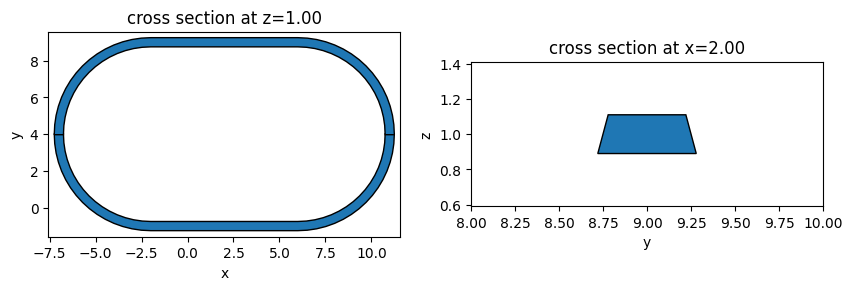

In [9]:
race_track = race_track_resonator(
    x0=2,
    y0=4,
    z0=1,
    R=5,
    wg_length=8,
    wg_width=0.5,
    wg_thickness=0.22,
    medium=Si,
    sidewall_angle=15 * np.pi / 180,
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
race_track.plot(z=1, ax=ax1)
race_track.plot(x=2, ax=ax2)
ax2.set_xlim(8, 10)
plt.show()

## Waveguide Cosine S-bend

Waveguide s-bends are commonly used in various PIC devices. The function `cosine_sbend` defines an s-bend using the cosine bend profile. Other s-bend profiles such as `circular`, `sigmoid`, or `tanh` can be incorporated in the same way. The cosine s-bend here interfaces with waveguides in the $x$ or $y$ direction and its bend direction can be controlled by the `mirror` parameter.

In [10]:
def cosine_sbend(
    x0,
    y0,
    z0,
    wg_width,
    wg_thickness,
    bend_length,
    bend_height,
    medium,
    orientation="x",
    mirror=False,
    sidewall_angle=0,
):
    """
    This function defines a cosine waveguide bend and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the bend starting position (um)
    y0: y coordinate of the bend starting position (um)
    z0: z coordinate of the bend starting position (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    bend_length: length of the bend (um)
    bend_height: height of the bend (um)
    medium: medium of the waveguide
    orientation: orientation of the bend, either 'x' or 'y'
    mirror: whether to mirror bend
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("bend")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width, layer=1, datatype=0)  # define a path

    if orientation == "x":
        # define cosine bend for x orientation
        path.segment(
            (x0 + bend_length, y0),
            offset=lambda u: -bend_height * np.cos(np.pi * (u)) / 2 + bend_height / 2,
        )
        # check if mirroring is needed
        if mirror == True:
            path.mirror((x0 + 1, y0), (x0, y0))

    elif orientation == "y":
        # define cosine bend for x orientation
        path.segment(
            (x0, y0 + bend_length),
            offset=lambda u: -bend_height * np.cos(np.pi * (u)) / 2 + bend_height / 2,
        )
        # check if mirroring is needed
        if mirror == True:
            path.mirror((x0, y0 + 1), (x0, y0))

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    bend_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    bend = td.Structure(geometry=bend_geo[0], medium=medium)

    return bend

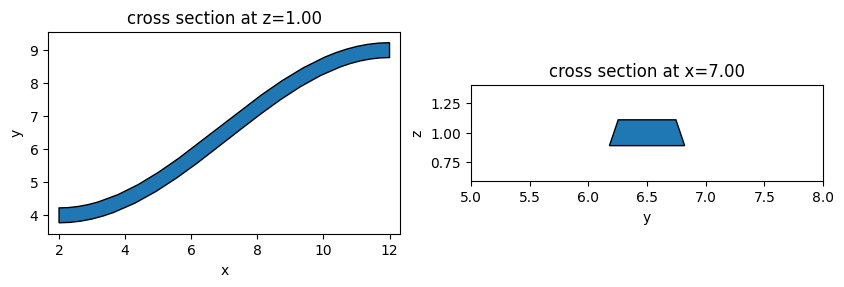

In [11]:
bend = cosine_sbend(
    x0=2,
    y0=4,
    z0=1,
    wg_width=0.45,
    wg_thickness=0.22,
    bend_length=10,
    bend_height=5,
    medium=Si,
    orientation="x",
    mirror=False,
    sidewall_angle=15 * np.pi / 180,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bend.plot(z=1, ax=ax1)
bend.plot(x=7, ax=ax2)
ax2.set_xlim(5, 8)
plt.show()

## Waveguide Circular Bend

Circular bends with an arbitrary bending angle and radius can be defined using the `circular_bend` function. Similar to the s-bend, the circular bend here interfaces with waveguides in the $x$ or $y$ direction and its bend direction can be controlled by the `mirror` parameter.

In [12]:
def circular_bend(
    x0,
    y0,
    z0,
    R,
    bend_angle,
    wg_width,
    wg_thickness,
    medium,
    orientation="x",
    mirror=False,
    sidewall_angle=0,
):
    """
    This function defines a circular waveguide bend and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the bend starting position (um)
    y0: y coordinate of the bend starting position (um)
    z0: z coordinate of the bend starting position (um)
    R: radius of the circular bend (um)
    bend_angle: angle of the bend (rad)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    orientation: orientation of the bend, either 'x' or 'y'
    mirror: whether to mirror bend
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("bend")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width, layer=1, datatype=0)  # define a path

    if orientation == "x":
        # define cosine bend for x orientation
        path.arc(R, -np.pi / 2, -np.pi / 2 + bend_angle)
        # check if mirroring is needed
        if mirror == True:
            path.mirror((x0 + 1, y0), (x0, y0))

    elif orientation == "y":
        # define cosine bend for x orientation
        path.arc(R, np.pi, np.pi - bend_angle)
        # check if mirroring is needed
        if mirror == True:
            path.mirror((x0, y0 + 1), (x0, y0))

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    bend_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    bend = td.Structure(geometry=bend_geo[0], medium=medium)

    return bend

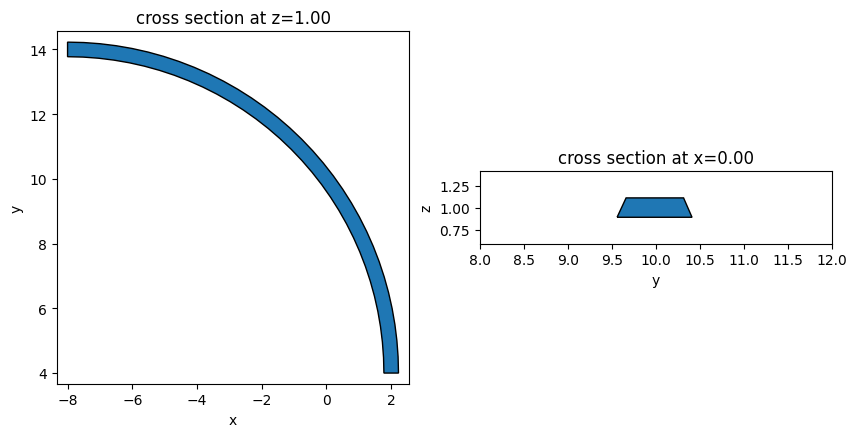

In [13]:
bend = circular_bend(
    x0=2,
    y0=4,
    z0=1,
    R=10,
    bend_angle=np.pi / 2,
    wg_width=0.45,
    wg_thickness=0.22,
    medium=Si,
    orientation="y",
    mirror=True,
    sidewall_angle=15 * np.pi / 180,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bend.plot(z=1, ax=ax1)
bend.plot(x=0, ax=ax2)
ax2.set_xlim(8, 12)
plt.show()

## Directional Coupler 

A directional coupler (DC) composes of two waveguides brought into close proximity for a certain length. The function `directional_coupler` defines a symmetric DC.

In [14]:
def directional_coupler(
    x0,
    y0,
    z0,
    wg_width,
    wg_thickness,
    wg_spacing_in,
    wg_spacing_coup,
    wg_length,
    coup_length,
    bend_length,
    medium,
    sidewall_angle=0,
):

    """
    This function defines a directional coupler and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of directional coupler center (um)
    y0: y coordinate of directional coupler center (um)
    z0: z coordinate of directional coupler center (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    wg_spacing_in : spacing between the input straight waveguides (um)
    wg_spacing_coup: gap size of the coupling region (um)
    wg_length: length of the input straight waveguides (um)
    coup_length：length of the coupling region (um)
    bend_length: length of the bending (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("dc")  # define a gds cell

    # define a path
    coup = gdstk.RobustPath(
        (-wg_length - bend_length - coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        wg_width,
        layer=1,
        datatype=0,
    )

    coup.segment((-bend_length - coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    A = (wg_spacing_in - wg_spacing_coup - wg_width) / 4

    coup.segment(
        (-coup_length / 2 + x0, wg_spacing_in / 2 + y0), offset=lambda u: A * np.cos(np.pi * u) - A
    )

    coup.segment((coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    coup.segment(
        (bend_length + coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        offset=lambda u: -A * np.cos(np.pi * u) - A,
    )
    coup.segment((wg_length + bend_length + coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    # add path to the cell
    cell.add(coup)

    # add the mirrored path to the cell
    cell.add(coup.copy().mirror((x0 + 1, y0), (x0, y0)))

    # define geometry from the gds cell
    dc_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    dc = td.Structure(geometry=td.GeometryGroup(geometries=dc_geo), medium=medium)

    return dc

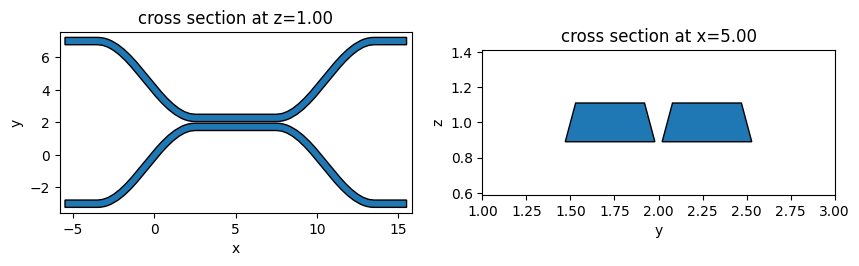

In [15]:
dc = directional_coupler(
    x0=5,
    y0=2,
    z0=1,
    wg_spacing_in=10,
    wg_width=0.45,
    wg_thickness=0.22,
    wg_spacing_coup=0.1,
    coup_length=5,
    bend_length=6,
    wg_length=2,
    medium=Si,
    sidewall_angle=15 * np.pi / 180,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
dc.plot(z=1, ax=ax1)
dc.plot(x=5, ax=ax2)
ax2.set_xlim(1, 3)
plt.show()